In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import loadtxt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from lightgbm import LGBMClassifier
import lightgbm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
import nltk
from string import punctuation
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import matplotlib.pyplot as plt
import time
import pytz
from datetime import datetime
from sklearn.metrics import classification_report
import pickle
import numpy as np
import matplotlib.pyplot as plt
import graphviz


class Main:     
    def show_current_time(self):
        ini = time.time()
        tz_SP = pytz.timezone('America/Sao_Paulo') 
        now = datetime.now(tz_SP)
        current_time = now.strftime("%d/%m/%Y %H:%M:%S")
        print("Current Time =", current_time)  
        

base_path = 'D:/'
#base_path = '/content/drive/My Drive/Colab Notebooks/'

print("Versão dopandas: " + pd.__version__)  
  

Versão dopandas: 1.0.5


In [2]:
fx = Main()

fx.show_current_time()

os.chdir(base_path+'/dou')

infile = open('X.pkl','rb')
X = pickle.load(infile)
infile.close()

infile = open('y.pkl','rb')
y = pickle.load(infile)
infile.close()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

infile = open('X_d.pkl','rb')
X_d = pickle.load(infile)
infile.close()

infile = open('y_d.pkl','rb')
y_d = pickle.load(infile)
infile.close()

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.3,
                                                    random_state=42, stratify = y_d)
print()
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print()
print(X_train_d.shape)
print(X_test_d.shape)
print(y_train_d.shape)
print(y_test_d.shape)

fx.show_current_time()

Current Time = 06/10/2020 15:48:17

(816, 100152)
(350, 100152)
(816,)
(350,)

(450, 100152)
(194, 100152)
(450,)
(194,)
Current Time = 06/10/2020 15:48:31


Treinamento dos Classificadores

Current Time = 06/10/2020 15:48:31
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
-------classes balanceadas-----------
              precision    recall  f1-score   support

           0     1.0000    0.9636    0.9815       165
           1     0.9686    1.0000    0.9840       185

    accuracy                         0.9829       350
   macro avg     0.9843    0.9818    0.9828       350
weighted avg     0.9834    0.9829    0.9828       350

-------classes desbalanceadas--------

              precision    recall  f1-score   support

           0     0.9607    0.9661    0.9634       177
           1     0.6250    0.5882    0.6061        17

    accuracy                         0.9330       194
   macro avg     0.7928    0.7772    0.7847       194
weighted avg     0.9313    0.9330    0.9321       194

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
-------classes balanceadas-----------
              precision    recall  f1-score   support

           0     0.9096    0

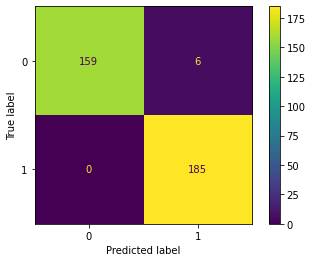

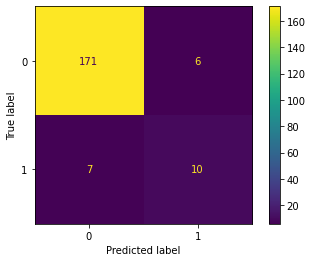

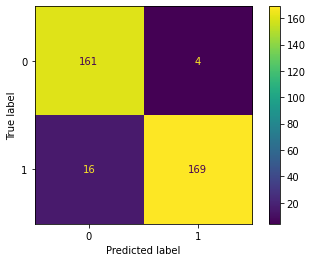

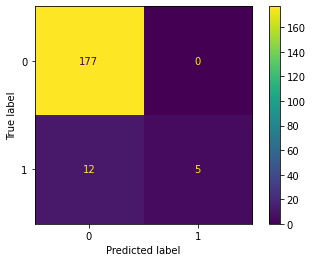

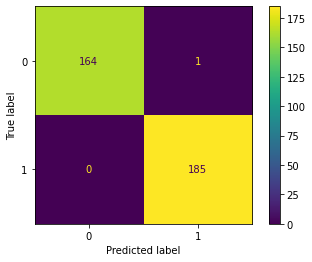

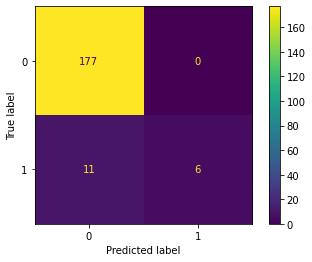

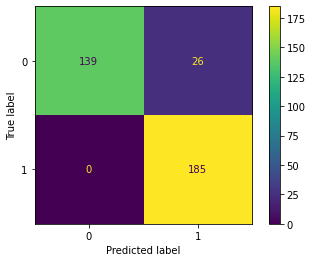

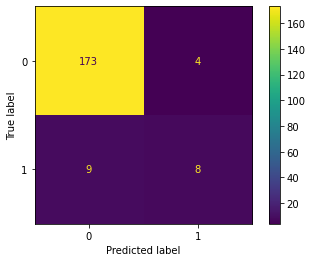

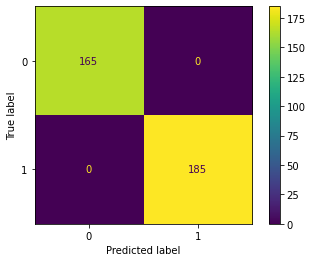

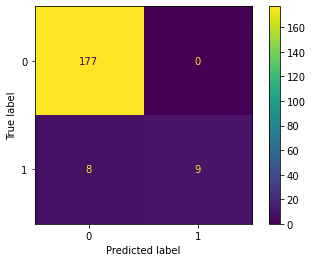

In [3]:
fx = Main()

fx.show_current_time()

lista_clf = [DecisionTreeClassifier(random_state=0, max_depth=10),
             RandomForestClassifier(n_estimators=10, max_depth=10),
             GaussianNB(),
             KNeighborsClassifier(algorithm='auto', leaf_size=30, 
                                  metric='minkowski',metric_params=None, 
                                  n_jobs=None, n_neighbors=5, p=2,
                                 weights='uniform'),
             LGBMClassifier(n_estimators = 100,learning_rate = 0.05,
                            max_depth = -1,n_jobs=-1, objective='binary',
                            num_leaves=13)]
model_clf ={}
for c in lista_clf: 
    print(type(c))
    print('-------classes balanceadas-----------')
    clf = c.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = confusion_matrix(y_test, y_pred) 
    print(classification_report(y_test, y_pred, target_names=['0','1'], digits=4))
    plot_confusion_matrix(clf, X_test, y_test) 
    print('-------classes desbalanceadas--------')
    clf_d = c.fit(X_train_d, y_train_d)
    y_pred_d = clf_d.predict(X_test_d)    
    print()
    acc_d = confusion_matrix(y_test_d, y_pred_d)
    print(classification_report(y_test_d, y_pred_d, target_names=['0','1'], digits=4))
    plot_confusion_matrix(clf_d, X_test_d, y_test_d)
    
    model_clf[type(c)] = [clf,clf_d]
    
fx.show_current_time()    
    

In [4]:
fx = Main()

fx.show_current_time()

#Adapted from https://www.kaggle.com/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761
n_iter = 10
param_test ={'n_estimators' : [10,20,50,80,100],
             'learning_rate' : [0.10,0.05,0.01,0.001],
             'max_depth' : [-1,5,10,20,30,50,100],
             'n_jobs':[-1,1,2,3,4], 
             'objective':['binary'],
             'num_leaves': sp_randint(6, 50)             
            }

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 10,
            'categorical_feature': 'auto'}

clf = LGBMClassifier(max_depth=-1, random_state=314, silent=True,
                     metric='accuracy', n_jobs=4, n_estimators=100)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=3,
    refit=True,
    random_state=314,
    verbose=False)
search = gs.fit(X_train, y_train, **fit_params)
#print(search.cv_results_)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))
fx.show_current_time()

Current Time = 06/10/2020 15:51:36
Training until validation scores don't improve for 30 rounds
[10]	valid's auc: 0.999148
[20]	valid's auc: 0.999902
Did not meet early stopping. Best iteration is:
[13]	valid's auc: 1
Training until validation scores don't improve for 30 rounds
[10]	valid's auc: 0.992531
[20]	valid's auc: 0.996396
Did not meet early stopping. Best iteration is:
[20]	valid's auc: 0.996396
Training until validation scores don't improve for 30 rounds
[10]	valid's auc: 0.993153
[20]	valid's auc: 0.999181
Did not meet early stopping. Best iteration is:
[20]	valid's auc: 0.999181
Training until validation scores don't improve for 30 rounds
[10]	valid's auc: 0.991794
Did not meet early stopping. Best iteration is:
[9]	valid's auc: 0.992121
Training until validation scores don't improve for 30 rounds
[10]	valid's auc: 0.985438
Did not meet early stopping. Best iteration is:
[7]	valid's auc: 0.98552
Training until validation scores don't improve for 30 rounds
[10]	valid's auc: 

Current Time = 06/10/2020 15:52:36
<class 'lightgbm.sklearn.LGBMClassifier'>
-------classes balanceadas-----------
              precision    recall  f1-score   support

           0     1.0000    0.9939    0.9970       165
           1     0.9946    1.0000    0.9973       185

    accuracy                         0.9971       350
   macro avg     0.9973    0.9970    0.9971       350
weighted avg     0.9972    0.9971    0.9971       350

-------classes desbalanceadas--------

              precision    recall  f1-score   support

           0     0.9568    1.0000    0.9779       177
           1     1.0000    0.5294    0.6923        17

    accuracy                         0.9588       194
   macro avg     0.9784    0.7647    0.8351       194
weighted avg     0.9605    0.9588    0.9529       194

Current Time = 06/10/2020 15:52:40


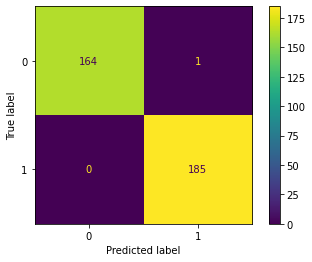

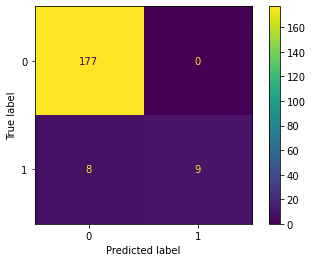

In [5]:
fx = Main()

fx.show_current_time()

lista_clf = [LGBMClassifier(learning_rate= 0.05, max_depth= -1, 
                             n_estimators= 80, n_jobs= 3, num_leaves= 15, objective= 'binary',
                             random_state=314, silent=True, metric='accuracy')]

for c in lista_clf: 
    print(type(c))
    print('-------classes balanceadas-----------')
    clf = c.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = confusion_matrix(y_test, y_pred) 
    print(classification_report(y_test, y_pred, target_names=['0','1'], digits=4))
    plot_confusion_matrix(clf, X_test, y_test) 
    print('-------classes desbalanceadas--------')
    clf_d = c.fit(X_train_d, y_train_d)
    y_pred_d = clf_d.predict(X_test_d)    
    print()
    acc_d = confusion_matrix(y_test_d, y_pred_d)
    print(classification_report(y_test_d, y_pred_d, target_names=['0','1'], digits=4))
    plot_confusion_matrix(clf_d, X_test_d, y_test_d)
    
    model_clf[type(c)] = [clf,clf_d]
    
fx.show_current_time()    
    

In [6]:
 clf = model_clf[type(LGBMClassifier())][0]
print('best iteration:',clf.best_iteration_)
print('best score:',clf.best_score_)
print('booster:',clf.booster_)
print('classes:',clf.classes_)
print('evals result:',clf.evals_result_)
print('feature importances:')
print(clf.feature_importances_)
print('number of classes:',clf.n_classes_)
print('number of features:',clf.n_features_)
print('number of features of fitted model:',clf.n_features_in_)
print('objective:',clf.objective_)

df_tree = clf.booster_.trees_to_dataframe()
df_tree[df_tree['tree_index']==79]



best iteration: None
best score: defaultdict(<class 'collections.OrderedDict'>, {})
booster: <lightgbm.basic.Booster object at 0x000001F2D9CA9970>
classes: [0 1]
evals result: None
feature importances:
[0 0 6 ... 0 0 0]
number of classes: 2
number of features: 100152
number of features of fitted model: 100152
objective: binary


,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
2267,79,1,79-S0,79-S1,79-S10,None,Column_88637,0.582411,0.011776,<=,left,None,0.000000,0.000000,450
2268,79,2,79-S1,79-S2,79-L2,79-S0,Column_9173,0.576826,0.020377,<=,left,None,0.003846,5.603260,351
2269,79,3,79-S2,79-S3,79-L3,79-S1,Column_24717,0.499380,0.017787,<=,left,None,0.008500,5.168370,312
2270,79,4,79-S3,79-S4,79-L4,79-S2,Column_8437,0.754605,0.004390,<=,left,None,-0.000354,3.902030,293
2271,79,5,79-S4,79-S5,79-L5,79-S3,Column_35741,0.979620,0.055688,<=,left,None,-0.013664,2.855650,262
2272,79,6,79-S5,79-S6,79-L6,79-S4,Column_4760,0.813781,0.011545,<=,left,None,-0.027879,2.311160,254
2273,79,7,79-S6,79-S7,79-L7,79-S5,Column_32151,0.416561,0.012059,<=,left,None,-0.043726,1.798170,232
2274,79,8,79-S7,79-S8,79-L8,79-S6,Column_74858,0.001201,0.019804,<=,left,None,-0.051345,1.634330,223
2275,79,9,79-S8,79-S9,79-L9,79-S7,Column_92672,0.000207,0.026622,<=,left,None,-0.050888,1.467340,221
2276,79,10,79-S9,79-S11,79-L10,79-S8,Column_42534,0.000123,0.013219,<=,left,None,-0.050695,1.327360,217


In [7]:
caminho = "D:/dou/2019/2019.csv"
df_2019 = pd.read_csv(caminho)
os.chdir('D:/dou')

infile = open('hot_encoder_treina.pkl','rb')
hot_enc = pickle.load(infile)
infile.close()

infile = open('pipeline_treina.pkl','rb')
pipe = pickle.load(infile)
infile.close()

result = np.where(clf.feature_importances_ > 0.01)
#print(result[0])
terms =[]
indexes=[]
values=[]
for r in result[0]:
    voc = pipe['count'].vocabulary_
    if(r < 100000):
        terms.append(list(voc.keys())[list(voc.values()).index(r)])
        indexes.append(r)
        values.append(clf.feature_importances_[r])
        #print(list(voc.keys())[list(voc.values()).index(r)],r, clf.feature_importances_[r],sep=',')
data = {
        'term': terms,
        'index': indexes,
        'weigth': values}        
df_importances = pd.DataFrame(data, columns = ['term', 'index', 'weigth']) 
df_importances.sort_values(by=['weigth'], inplace=True, ascending=False)
print(len(df_importances))
df_importances.head(50)


253


,term,index,weigth
69,criar,24717,95
21,assuntos,8437,38
95,ensino,35741,35
250,âmbito,99426,25
65,coordenar,23289,25
92,elaborar,33884,23
46,comitê,17607,21
75,decreto,26856,21
70,criação,24759,17
49,competências,17992,17


In [8]:
df_2019 =  df_2019[df_2019.texto.isnull()==False].sample(
    n=3000, random_state=14)
corpus = df_2019['texto']
X_2019_words = pipe.transform(corpus).toarray()
X_2019_tipo = hot_enc.transform(df_2019[['tipo']])

X_2019 = np.concatenate((X_2019_words,X_2019_tipo),axis=1)
del X_2019_words, X_2019_tipo, pipe , hot_enc

clf = model_clf[type(LGBMClassifier())][0] 
y_2019_pred = clf.predict(X_2019)
result = np.where(y_2019_pred == 1)
contador = 0
for artigo in df_2019.iloc[result[0]]['texto']:
    print(artigo)
    print()
    contador = contador + 1
    print('achados :',contador)

DECRETO Nº 9.931, DE 23 DE JULHO DE 2019Institui o Grupo Interministerial de Propriedade Intelectual.O PRESIDENTE DA REPÚBLICA, no uso da atribuição que lhe confere o art. 84,caput, inciso VI, alínea "a", da Constituição,D E C R E T A :Art. 1º Fica instituído o Grupo Interministerial de Propriedade Intelectual - Gipi, no âmbito do Ministério da Economia, com a finalidade de propor ações e coordenar a atuação do Governo federal no tema propriedade intelectual.Art. 2º O Gipi terá as seguintes atribuições:I - elaborar anualmente seu plano de trabalho, que conterá o cronograma de suas atividades e estabelecerá as ações prioritárias;II - promover a coesão das ações, dos programas, dos projetos e das iniciativas dos órgãos e entidades públicas com competências relativas ao tema propriedade intelectual;III - manifestar-se sobre atos normativos que disponham sobre o tema propriedade intelectual e temas correlatos;IV - propor a celebração de tratados, convenções e atos internacionais, bilaterai